# Bike Sharing Demand 

Biggest score inscrease gave the training for log(x + 1) since the competition score is RMSE. Trying around with models and a little bit of feature engineering helped too.

Old kaggle competition: https://www.kaggle.com/c/bike-sharing-demand

Description from kaggle: You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

datetime - hourly date + timestamp  
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter   
holiday - whether the day is considered a holiday  
workingday - whether the day is neither a weekend nor holiday  
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy   
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist   
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds    
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog   
temp - temperature in Celsius  
atemp - "feels like" temperature in Celsius  
humidity - relative humidity  
windspeed - wind speed  
casual - number of non-registered user rentals initiated  
registered - number of registered user rentals initiated  
count - number of total rentals  

In [238]:
%matplotlib inline
import re
from time import time
from datetime import datetime
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
df_train = pd.read_csv('train.csv', parse_dates=['datetime'])
df_test = pd.read_csv('test.csv', parse_dates=['datetime'])

# Feature engineering
def feature_eng(df):
    df['year'] = df['datetime'].apply(lambda x: x.year)
    df['hour'] = df['datetime'].apply(lambda x: x.hour)
    df['weekday'] = df['datetime'].apply(lambda x: x.weekday())
    df['month'] = df['datetime'].apply(lambda x: x.month)
    df = pd.get_dummies(df, columns=['season', 'weather', 'year', 'month', 'weekday']) # hour reduces score
    
    # manual engineering
    df['humidity_atemp'] = df['humidity'] * df['atemp']
    df['workingday_hum'] = df['workingday'] * df['humidity']
    df['hour_0_6'] = df['hour'].apply(lambda x: 1 if x<=6 else 0)
    df['hour_7_8'] = df['hour'].apply(lambda x: 1 if x==7 or x==8 else 0)
    df['hour_9_10_11'] = df['hour'].apply(lambda x: 1 if x==9 or x==10 or x==11 else 0)
    df['hour_12_18'] = df['hour'].apply(lambda x: 1 if (x>=12) and (x<18) else 0)
    df['hour_18_24'] = df['hour'].apply(lambda x: 1 if x>=18 else 0)
    
    df['month_1_3'] = df['month_1'] + df['month_2'] + df['month_3']
    df.drop(['month_1', 'month_2', 'month_3'], axis=1, inplace=True)
    #df['temp_atemp'] = df['temp'] + df['atemp']
    #df['windspeed_temp'] = df['windspeed'] * df['temp']
    #df['humidity_windspeed'] = df['humidity'] * df['windspeed']
    #df['hour_mid'] = df['hour_12'] + df['hour_13']
    #df['hour_ev'] = df['hour_20'] + df['hour_21'] + df['hour_22']
    
    #df.drop(['hour_12', 'hour_13', 'hour_20', 'hour_21', 'hour_22'], axis=1, inplace=True)
    # day into 4 6-hour blocks
    return df

df_train = feature_eng(df_train)    
df_test = feature_eng(df_test)

# Memory optimization
# Technical stuff, contributes nothing to analysis
for df in [df_train, df_test]:
    conv = df.select_dtypes(include=['int', 'float']).apply(pd.to_numeric,downcast='unsigned')
    df[conv.columns] = conv

X = df_train.drop(['casual', 'registered', 'count', 'datetime'], axis=1)
X2 = df_test.drop(['datetime'], axis=1)
y = df_train[['count']]#.apply(lambda x: log(x + 1))

from sklearn.model_selection import train_test_split, learning_curve
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

def plot_learning_curve(estimator, X, y, cv=None, ylim=None, n_jobs=1, train_sizes=np.linspace(.3, 1.0, 3)):
    plt.figure()
    plt.title('Learning curve')
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples'); plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


print("training data: ", len(X_train))
print("columns:", len(df_train.columns))
df_train.head(3)
#list(df_train.columns)
#df_train.corr()
#df_train.describe()

training data:  7620
columns: 45


,datetime,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,...,weekday_5,weekday_6,humidity_atemp,workingday_hum,hour_0_6,hour_7_8,hour_9_10_11,hour_12_18,hour_18_24,month_1_3
0,2011-01-01 00:00:00,0,0,9.84,14.395,81,0.0,3,13,16,...,1,0,1165.995,0,1,0,0,0,0,1
1,2011-01-01 01:00:00,0,0,9.02,13.635,80,0.0,8,32,40,...,1,0,1090.800,0,1,0,0,0,0,1
2,2011-01-01 02:00:00,0,0,9.02,13.635,80,0.0,5,27,32,...,1,0,1090.800,0,1,0,0,0,0,1


R^2: 0.957
Score: 0.0052


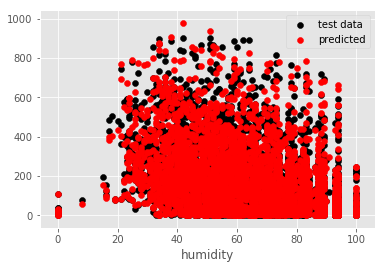

Done in 0.21 min.


In [242]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, Normalizer
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

y = df_train['count'].apply(lambda x: np.log(x + 1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
st = time()
pipe = Pipeline([
    ('scaler', StandardScaler()),
    # 0.957 , score 0.0052 with log(x + 1)
    ('ensemble', GradientBoostingRegressor(learning_rate=0.1, max_depth=4, n_estimators=600))
    # for casual now
    #('ensemble', GradientBoostingRegressor(learning_rate=0.1, max_depth=5, n_estimators=800))
    # 0.940
    #('tree', RandomForestRegressor(n_estimators=1000, min_samples_split=11, n_jobs=-1))
])
#pipe2 = Pipeline([
#    ('scaler', StandardScaler()),
#    ('ensemble', GradientBoostingRegressor(learning_rate=0.1, max_depth=5, n_estimators=600))
#])


# Choose what you want to do
if False:
    plot_learning_curve(pipe, X, y, cv=3, n_jobs=-1, #ylim=[-1, 1],
                       train_sizes=np.linspace(.5, 1.0, 3))
    plt.show()

if True:
    #y = df_train[['casual']]
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    #y_pred[np.where(y_pred < 0)] = 0
    
    """
    y = df_train[['registered']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    pipe2.fit(X_train, y_train)
    y_pred2 = pipe2.predict(X_test)
    y_pred2[np.where(y_pred2 < 0)] = 0
    
    y_pred_count = y_pred + y_pred2
    """
    print("R^2: %1.3f" % r2_score(y_test, y_pred))
    #print("Explained var: {:.2f}".format(explained_variance_score(y_test, y_pred)))
    #print("Mean absolute err: {:.2f}".format(mean_absolute_error(y_test, y_pred)))
    #print("Mean squared err: {:.3f}".format(mean_squared_error(y_test, y_pred)))
    print("Score: {:.4f}".format(sqrt(mean_squared_error(y_test, y_pred)/len(y_test))))
    # Residual plot
    X_res = X_test['humidity']
    plt.scatter(X_res, np.exp(y_test) - 1, color='black', label='test data')
    plt.scatter(X_res, np.exp(y_pred) - 1, color='red', label='predicted')
    plt.xlabel('humidity')
    plt.legend(); plt.show()
    
if False:
    #y = df_train[['casual']]
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    from sklearn.model_selection import GridSearchCV
    param_grid = {
        #'model__alpha': [1e-1, 1e0, 1e1],
        #'model__hidden_layer_sizes': [(100,), (100, 50)]
        #'ensemble__learning_rate': [1e-2, 1e-1, 1e0],
        'ensemble__max_depth': [4, 5, 6],
        'ensemble__n_estimators': [600, 800, 1000],
                 }
    grid = GridSearchCV(pipe, param_grid, cv=3, n_jobs=-1)
    grid.fit(X_train, y_train)
    print(grid.best_params_)

print('Done in {:.2f} min.'.format((time() - st)/60))
# Make yourself noticeable to human
#import os; os.system('say -r 150 "beebeep, beebeep"')

In [243]:
# Find out which features are important
features = {}
for i, col in enumerate(X_test.columns):
    features[col] = pipe.named_steps['ensemble'].feature_importances_[i]

import operator
s = sorted(features.items(), key=operator.itemgetter(1), reverse=True)
s


[('hour', 0.23311640389008986),
 ('humidity_atemp', 0.12216462494391765),
 ('workingday_hum', 0.072389242346273364),
 ('windspeed', 0.068271203986924558),
 ('humidity', 0.05566686373883923),
 ('temp', 0.049504964820052517),
 ('workingday', 0.039196607347774616),
 ('atemp', 0.037602538157849683),
 ('weekday_6', 0.026630305858270892),
 ('hour_7_8', 0.02395061156223741),
 ('holiday', 0.019438664205912237),
 ('weather_3', 0.018607607280448833),
 ('month_4', 0.016665258474088222),
 ('weekday_2', 0.013786677222598168),
 ('year_2011', 0.01365884218265369),
 ('weekday_0', 0.013127468665856757),
 ('weekday_5', 0.012862260720467346),
 ('hour_12_18', 0.011942719562913045),
 ('weekday_1', 0.011615241321093634),
 ('hour_0_6', 0.010637218479165862),
 ('year_2012', 0.010422106631409359),
 ('month_5', 0.010258139043805188),
 ('weather_2', 0.0093843760739875919),
 ('month_9', 0.0091636365308347852),
 ('weekday_4', 0.0088350051871487461),
 ('hour_9_10_11', 0.008596282765307002),
 ('weather_1', 0.0085911

In [244]:
# Use model for submission
pipe.fit(X, y)
y_pred_count = pipe.predict(X2)
y_pred_count = np.exp(y_pred_count) - 1

In [245]:
# There are negative values, for the moment let's just correct them
y_pred_count[np.where(y_pred_count < 0)] = 0
df_sub = pd.DataFrame({'datetime': list(df_test['datetime'].values), 'count': y_pred_count})
df_sub.to_csv('submission.csv', columns=['datetime', 'count'], index=False)
df_sub


,count,datetime
0,11.822609,2011-01-20 00:00:00
1,5.307982,2011-01-20 01:00:00
2,3.155084,2011-01-20 02:00:00
3,2.267007,2011-01-20 03:00:00
4,1.755918,2011-01-20 04:00:00
5,5.727116,2011-01-20 05:00:00
6,36.145130,2011-01-20 06:00:00
7,104.338240,2011-01-20 07:00:00
8,225.984709,2011-01-20 08:00:00
9,125.394812,2011-01-20 09:00:00
